In [ ]:
=import pandas as pd

# Assuming you have loaded your dataset into a DataFrame 'df'
# Simulating the data loading step for context
# Load the dataset
data_path = '/content/household_data_2.csv'  # Update this path to your dataset location
df = pd.read_csv(data_path)


# Compute non-cumulative values
df_non_cumulative = df[['utc_timestamp']].copy()
df_non_cumulative['grid_import'] = df['grid_import'].diff().fillna(df['grid_import'])
df_non_cumulative['pv'] = df['pv'].diff().fillna(df['pv'])
df_non_cumulative['storage_charge'] = df['storage_charge'].diff().fillna(df['storage_charge'])
df_non_cumulative['storage_decharge'] = df['storage_decharge'].diff().fillna(df['storage_decharge'])

# Save to a new CSV file
df_non_cumulative.to_csv('/content/non_cumulative_data.csv', index=False)

# Print the new dataset to verify
print(df_non_cumulative)

              utc_timestamp  grid_import        pv  storage_charge  \
0      2016-04-25T15:45:00Z     2293.708  5793.407           0.000   
1      2016-04-25T16:00:00Z        0.410     0.670           0.002   
2      2016-04-25T16:15:00Z        0.413     0.500           0.001   
3      2016-04-25T16:30:00Z        0.754     0.330           0.001   
4      2016-04-25T16:45:00Z        0.793     0.185           0.001   
...                     ...          ...       ...             ...   
30230  2017-03-06T13:15:00Z        0.105     0.516           0.000   
30231  2017-03-06T13:30:00Z        0.256     0.334           0.000   
30232  2017-03-06T13:45:00Z        0.670     0.189           0.004   
30233  2017-03-06T14:00:00Z        0.770     0.110           0.005   
30234  2017-03-06T14:15:00Z        0.846   666.739           0.005   

       storage_decharge  
0                 0.000  
1                 0.000  
2                 0.000  
3                 0.000  
4                 0.000  
...

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Episode: 24, Total Reward: 672105776.5680809
1/1 [==============================] - 0s 41ms/step
Episode: 25, Total Reward: 751436182.8149728
1/1 [==============================] - 0s 31ms/step
Episode: 26, Total Reward: 835949297.470327
1/1 [==============================] - 0s 22ms/step
Episode: 27, Total Reward: 925690281.9921848
1/1 [==============================] - 0s 30ms/step
Episode: 28, Total Reward: 1020699131.3399038
1/1 [==============================] - 0s 42ms/step
Episode: 29, Total Reward: 1121011986.3937826
1/1 [==============================] - 0s 29ms/step
Episode: 30, Total Reward: 1226661805.2403038
1/1 [==============================] - 0s 30ms/step
Episode: 31, Total Reward: 1337677933.22568
1/1 [==============================] - 0s 38ms/step
Episode: 32, Total Reward: 1454087235.0291061
1/1 [==============================] - 0s 22ms/step
Episode: 33, Total Rew

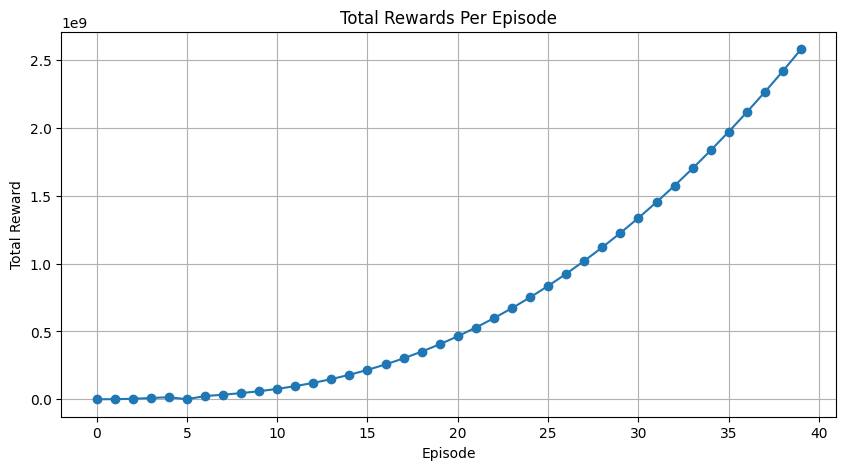

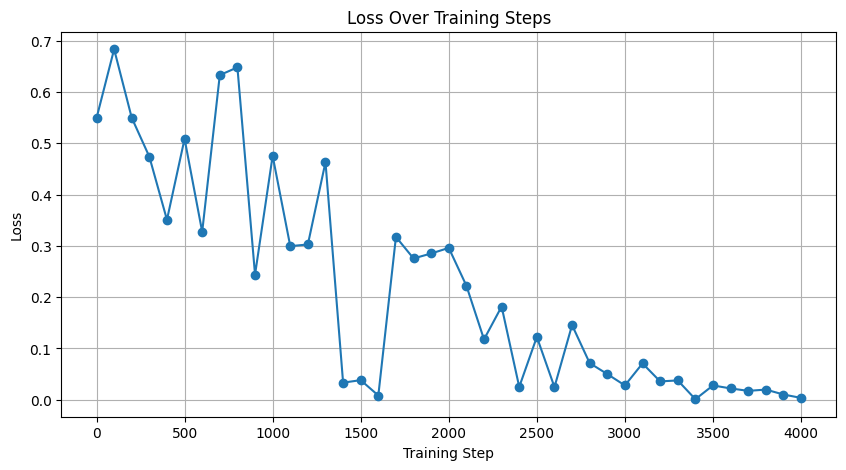

In [ ]:
import numpy as np
import gym
from gym import spaces
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class EnergyManagementEnv(gym.Env):
    """Custom environment that follows gym interface."""
    def __init__(self, data, max_steps_per_episode=100):
        super(EnergyManagementEnv, self).__init__()
        self.data = data
        self.n_steps = len(data)
        self.max_steps_per_episode = max_steps_per_episode
        self.current_step = 0
        # Define action and observation space
        # Actions: [discharge_rate, pv_utilization_rate]
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([1, 1]), dtype=np.float32)
        # Observation: grid_import, pv, storage_charge, storage_decharge
        self.observation_space = spaces.Box(low=np.zeros(4), high=np.inf*np.ones(4), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.data.iloc[0].values

    def step(self, action):
        discharge, pv_utilization = action
        grid_import, pv, storage_charge, storage_decharge = self.data.iloc[self.current_step].values
        reward = pv * pv_utilization - grid_import * 0.1 - abs(storage_charge - discharge) * 0.1

        self.current_step += 1
        done = self.current_step >= self.n_steps or self.current_step >= self.max_steps_per_episode
        next_state = self.data.iloc[self.current_step % self.n_steps].values if not done else np.zeros(4)

        return next_state, reward, done, {}

    def render(self, mode='human', close=False):
        if mode == 'console':
            print(f"Step: {self.current_step}, State: {self.data.iloc[self.current_step % self.n_steps]}")


# Create the Q-learning model
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = 0.01
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(0, 1, 2)
        act_values = self.model.predict(state)
        return act_values[0]

    def learn(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][np.argmax(action)] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

import pandas as pd
data = pd.read_csv('/content/non_cumulative_data.csv')  # Adjust path as necessary
env = EnergyManagementEnv(data[['grid_import', 'pv', 'storage_charge', 'storage_decharge']])
agent = QLearningAgent(env.observation_space.shape[0], 2)  # Actions are two-dimensional

import matplotlib.pyplot as plt

# Assuming you collect total rewards in a list named 'all_rewards'
all_rewards = []

num_episodes = 40

for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, 4])
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    all_rewards.append(total_reward)  # Append the total reward for this episode
    print(f'Episode: {episode+1}, Total Reward: {total_reward}')

# Plotting the total rewards after all episodes
plt.figure(figsize=(10, 5))
plt.plot(all_rewards, marker='o', linestyle='-')
plt.title('Total Rewards Per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt



# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(steps, loss, marker='o')
plt.title('Loss Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

